In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
df = pd.read_csv("nifty.csv")

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0.0
1,2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0.0
2,2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0.0
3,2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0.0
4,2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0.0
...,...,...,...,...,...,...,...
4114,2024-05-21,22404.550781,22591.099609,22404.550781,22529.050781,22529.050781,347600.0
4115,2024-05-22,22576.599609,22629.500000,22483.150391,22597.800781,22597.800781,290300.0
4116,2024-05-23,22614.099609,22993.599609,22577.449219,22967.650391,22967.650391,369800.0
4117,2024-05-24,22930.750000,23026.400391,22908.000000,22957.099609,22957.099609,261900.0


In [6]:
df = df[['Date', 'Close']]

In [7]:
df.loc[:, 'Date'] = pd.to_datetime(df['Date'])

In [8]:
df.set_index('Date', inplace=True)

d:\Downloads\nifty_prediction_LSTM_Keras\venv\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [9]:
df.fillna(method='ffill', inplace=True)

C:\Users\therealbhuvi\AppData\Local\Temp\ipykernel_7572\3970806690.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\therealbhuvi\AppData\Local\Temp\ipykernel_7572\3970806690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(method='ffill', inplace=True)


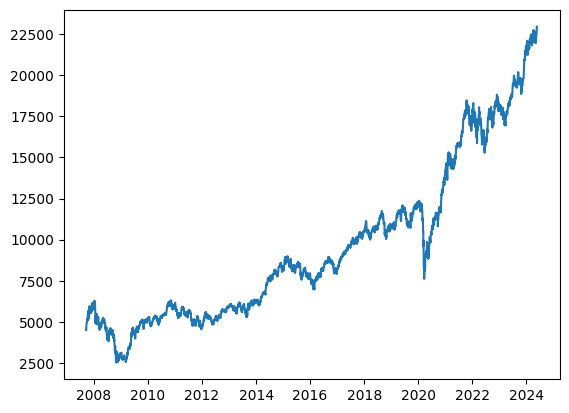

In [10]:
plt.plot(df.index, df['Close'])

In [11]:
df_close = df['Close'].values

training_data_len = int(np.ceil( len(df_close) * .8 ))
val_data_len = int(np.ceil(len(df_close) * .9))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_close.reshape(-1, 1))

dates_train = []
dates_val = []
dates_test = []
X_train = []
X_val = []
X_test = []
y_train = []
y_val = []
y_test = []

for i in range(60, training_data_len):
  dates_train.append(df.index.values[i])
  X_train.append(scaled_data[i-60:i, 0])
  y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


for i in range(training_data_len, val_data_len):
  dates_val.append(df.index.values[i])
  X_val.append(scaled_data[i-60:i, 0])
  y_val.append(scaled_data[i, 0])

X_val, y_val = np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

for i in range(val_data_len, len(scaled_data)):
  dates_test.append(df.index.values[i])
  X_test.append(scaled_data[i-60:i, 0])
  y_test.append(scaled_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

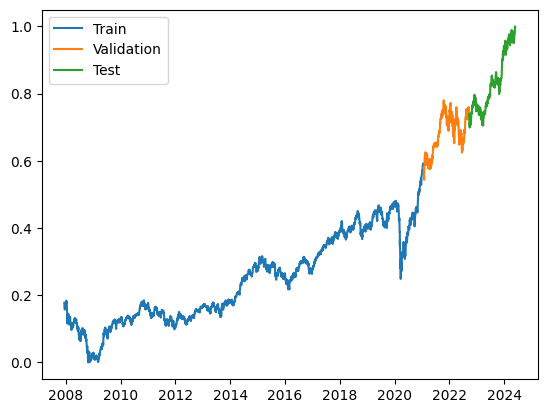

In [12]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test'])

In [13]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3236, 60, 1), (3236,), (412, 60, 1), (412,), (411, 60, 1), (411,))

In [14]:
def prediction(model, dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test):
  train_predictions = model.predict(X_train).flatten()
  val_predictions = model.predict(X_val).flatten()
  test_predictions = model.predict(X_test).flatten()

  plt.plot(dates_train, train_predictions)
  plt.plot(dates_train, y_train)
  plt.plot(dates_val, val_predictions)
  plt.plot(dates_val, y_val)
  plt.plot(dates_test, test_predictions)
  plt.plot(dates_test, y_test)

  plt.legend(['Train Predictions', 'Train Observations', 'Val Predictions', 'Val Observations', 'Test Predictions', 'Test Observations'])

  return train_predictions, val_predictions, test_predictions

In [15]:
model1 = Sequential([layers.Input((60, 1)),
                     layers.LSTM(64),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(1)])

model1.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0131 - mean_absolute_error: 0.0729 - val_loss: 2.9263e-04 - val_mean_absolute_error: 0.0131
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.0646e-05 - mean_absolute_error: 0.0064 - val_loss: 2.5902e-04 - val_mean_absolute_error: 0.0125
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.9180e-05 - mean_absolute_error: 0.0062 - val_loss: 2.4914e-04 - val_mean_absolute_error: 0.0124
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.9988e-05 - mean_absolute_error: 0.0062 - val_loss: 2.3751e-04 - val_mean_absolute_error: 0.0119
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.2191e-05 - mean_absolute_error: 0.0061 - val_loss: 2.2932e-04 - val_mean_absolute_error: 0.0116
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 6.8768e-05 - mean_absolute_error: 0.0060 - val_loss: 2.1952e-04 - val_mean_absolute_error: 0.0117
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


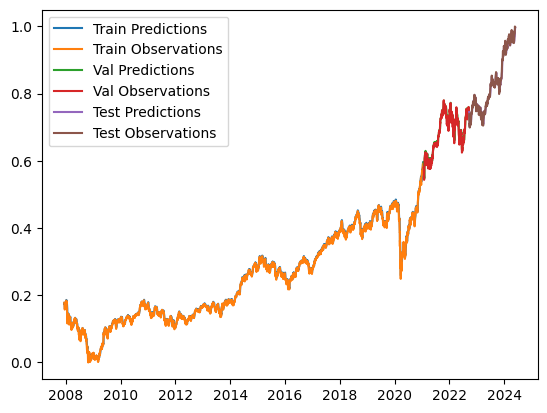

In [16]:
model1_preds = prediction(model1, dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test)

In [17]:
rmse_train = np.sqrt(np.mean(((model1_preds[0] - y_train) ** 2)))
rmse_val = np.sqrt(np.mean(((model1_preds[1] - y_val) ** 2)))
rmse_test = np.sqrt(np.mean(((model1_preds[2] - y_test) ** 2)))

rmse_train, rmse_val, rmse_test

(0.005186302574321478, 0.00981902422704301, 0.007482915837962343)

In [18]:
model2 = Sequential([layers.Input((60, 1)),
                     layers.LSTM(64),
                     layers.Dropout(0.2),
                     layers.Dense(32),
                     layers.Dense(1)])

model2.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model2_history = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0135 - mean_absolute_error: 0.0744 - val_loss: 2.6141e-04 - val_mean_absolute_error: 0.0128
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.7040e-04 - mean_absolute_error: 0.0169 - val_loss: 2.7732e-04 - val_mean_absolute_error: 0.0135
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.0567e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0012 - val_mean_absolute_error: 0.0309
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.5665e-04 - mean_absolute_error: 0.0133 - val_loss: 3.4995e-04 - val_mean_absolute_error: 0.0160
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2.7671e-04 - mean_absolute_error: 0.0120 - val_loss: 8.6286e-04 - val_mean_absolute_error: 0.0265
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.4942e-04 - mean_absolute_error: 0.0112 - val_loss: 2.4891e-04 - val_mean_absolute_error: 0.0130
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


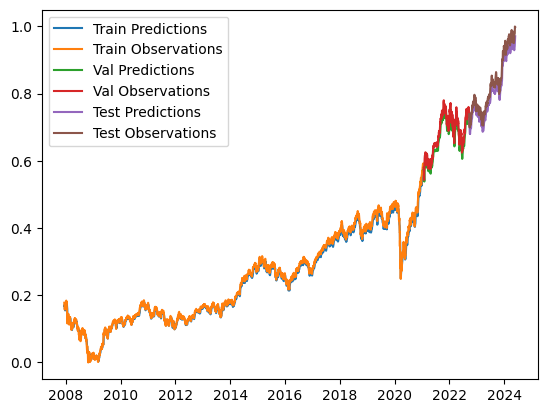

In [19]:
model2_preds = prediction(model2, dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test)

In [20]:
rmse_train = np.sqrt(np.mean(((model2_preds[0] - y_train) ** 2)))
rmse_val = np.sqrt(np.mean(((model2_preds[1] - y_val) ** 2)))
rmse_test = np.sqrt(np.mean(((model2_preds[2] - y_test) ** 2)))

rmse_train, rmse_val, rmse_test

(0.009403244755730488, 0.021323784121412333, 0.024296306065898565)

In [21]:
model3 = Sequential([layers.Input((60, 1)),
                     layers.LSTM(64),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(1)])

model3.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model3_history = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0375 - mean_absolute_error: 0.1608 - val_loss: 0.0064 - val_mean_absolute_error: 0.0772
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.6167e-04 - mean_absolute_error: 0.0260 - val_loss: 3.7504e-04 - val_mean_absolute_error: 0.0155
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.1456e-04 - mean_absolute_error: 0.0109 - val_loss: 0.0014 - val_mean_absolute_error: 0.0315
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.1680e-04 - mean_absolute_error: 0.0076 - val_loss: 9.9794e-04 - val_mean_absolute_error: 0.0254
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.0909e-04 - mean_absolute_error: 0.0070 - val_loss: 7.1921e-04 - val_mean_absolute_error: 0.0208
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.1744e-04 - mean_absolute_error: 0.0071 - val_loss: 7.7882e-04 - val_mean_absolute_error: 0.0220
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/ste

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


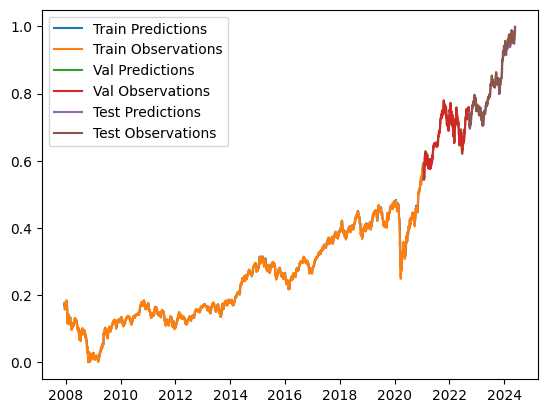

In [22]:
model3_preds = prediction(model3, dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test)

In [23]:
rmse_train = np.sqrt(np.mean(((model3_preds[0] - y_train) ** 2)))
rmse_val = np.sqrt(np.mean(((model3_preds[1] - y_val) ** 2)))
rmse_test = np.sqrt(np.mean(((model3_preds[2] - y_test) ** 2)))

rmse_train, rmse_val, rmse_test

(0.005387932903967885, 0.010222412292141372, 0.00913258784234835)

In [24]:
model4 = Sequential([
    layers.Input((60, 1)),
    layers.LSTM(128, return_sequences=True),
    Dropout(0.2),
    layers.LSTM(64),
    Dropout(0.2),
    layers.Dense(32, activation='relu'),
    Dropout(0.2),
    layers.Dense(1)
])

model4.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model4_history = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.0370 - mean_absolute_error: 0.1495 - val_loss: 0.0038 - val_mean_absolute_error: 0.0571
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0036 - mean_absolute_error: 0.0451 - val_loss: 0.0018 - val_mean_absolute_error: 0.0336
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0028 - mean_absolute_error: 0.0382 - val_loss: 0.0020 - val_mean_absolute_error: 0.0365
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0025 - mean_absolute_error: 0.0361 - val_loss: 0.0011 - val_mean_absolute_error: 0.0261
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0025 - mean_absolute_error: 0.0351 - val_loss: 6.2802e-04 - val_mean_absolute_error: 0.0198
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0022 - mean_absolute_error: 0.0335 - val_loss: 0.0028 - val_mean_absolute_error: 0.0465
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0023 - mean_absolut

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


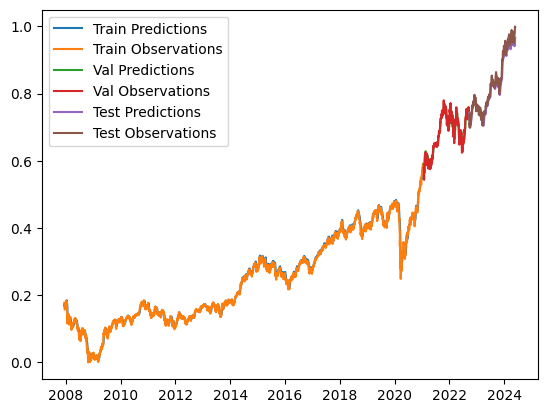

In [25]:
model4_preds = prediction(model4, dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test)

In [26]:
rmse_train = np.sqrt(np.mean(((model4_preds[0] - y_train) ** 2)))
rmse_val = np.sqrt(np.mean(((model4_preds[1] - y_val) ** 2)))
rmse_test = np.sqrt(np.mean(((model4_preds[2] - y_test) ** 2)))

rmse_train, rmse_val, rmse_test

(0.008331773302988928, 0.014331668701342984, 0.01600509598817473)

In [27]:
model5 = Sequential([layers.Input((60, 1)),
                     layers.LSTM(64),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(1)])

model5.compile(loss='mse', optimizer=Adam(learning_rate=0.0005), metrics=['mean_absolute_error'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model5_history = model5.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0146 - mean_absolute_error: 0.0778 - val_loss: 3.6559e-04 - val_mean_absolute_error: 0.0152
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.3180e-04 - mean_absolute_error: 0.0077 - val_loss: 4.4461e-04 - val_mean_absolute_error: 0.0173
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.0370e-04 - mean_absolute_error: 0.0071 - val_loss: 3.2575e-04 - val_mean_absolute_error: 0.0142
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.0378e-04 - mean_absolute_error: 0.0070 - val_loss: 3.1879e-04 - val_mean_absolute_error: 0.0141
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9.6152e-05 - mean_absolute_error: 0.0069 - val_loss: 3.3183e-04 - val_mean_absolute_error: 0.0146
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.9619e-05 - mean_absolute_error: 0.0063 - val_loss: 3.2551e-04 - val_mean_absolute_error: 0.0145
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


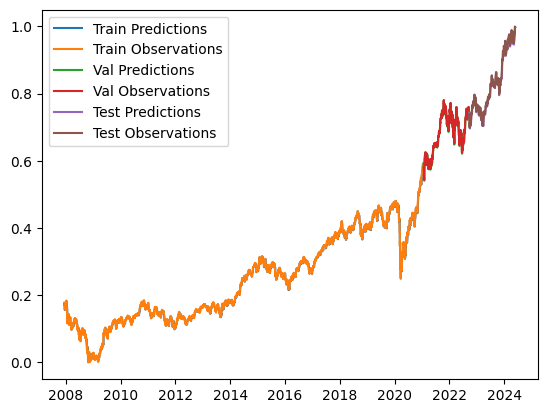

In [28]:
model5_preds = prediction(model5, dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test)

In [29]:
rmse_train = np.sqrt(np.mean(((model5_preds[0] - y_train) ** 2)))
rmse_val = np.sqrt(np.mean(((model5_preds[1] - y_val) ** 2)))
rmse_test = np.sqrt(np.mean(((model5_preds[2] - y_test) ** 2)))

rmse_train, rmse_val, rmse_test

(0.004612523678154355, 0.008885949234340372, 0.006771487128555459)

In [30]:
model6 = Sequential([
    layers.Input((60, 1)),  # Input shape: (timesteps, features)
    layers.LSTM(128, return_sequences=True),  # Output shape: (batch_size, timesteps, units)
    layers.LSTM(64),  # Output shape: (batch_size, units)
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model6.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model6_history = model6.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0099 - mean_absolute_error: 0.0574 - val_loss: 3.9935e-04 - val_mean_absolute_error: 0.0160
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 1.3869e-04 - mean_absolute_error: 0.0083 - val_loss: 8.2129e-04 - val_mean_absolute_error: 0.0249
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 1.3807e-04 - mean_absolute_error: 0.0080 - val_loss: 4.2582e-04 - val_mean_absolute_error: 0.0172
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 1.1902e-04 - mean_absolute_error: 0.0079 - val_loss: 3.1115e-04 - val_mean_absolute_error: 0.0141
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 1.3025e-04 - mean_absolute_error: 0.0084 - val_loss: 6.7280e-04 - val_mean_absolute_error: 0.0227
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 9.3347e-05 - mean_absolute_error: 0.0073 - val_loss: 0.0012 - val_mean_absolute_error: 0.0307
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


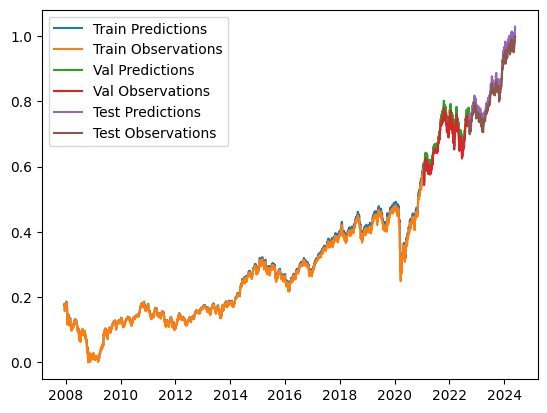

In [31]:
model6_preds = prediction(model6, dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test)

In [32]:
rmse_train = np.sqrt(np.mean(((model6_preds[0] - y_train) ** 2)))
rmse_val = np.sqrt(np.mean(((model6_preds[1] - y_val) ** 2)))
rmse_test = np.sqrt(np.mean(((model6_preds[2] - y_test) ** 2)))

rmse_train, rmse_val, rmse_test

(0.0070936529808467135, 0.01857146538830035, 0.02066787447206337)

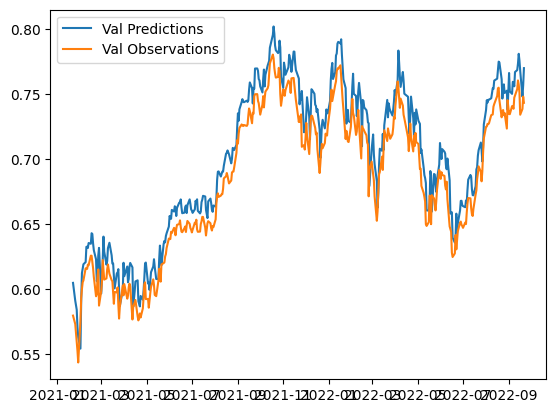

In [33]:
plt.plot(dates_val, model6_preds[1])
plt.plot(dates_val, y_val)
# plt.plot(dates_test, model6_preds[2])
# plt.plot(dates_test, y_test)

plt.legend(['Val Predictions', 'Val Observations', 'Test Predictions', 'Test Observations'])


In [35]:
model7 = Sequential([
    layers.Input((60, 1)),  # Input shape: (timesteps, features)
    layers.LSTM(128, return_sequences=True),  # Output shape: (batch_size, timesteps, units)
    layers.LSTM(128, return_sequences=True),  # Output shape: (batch_size, timesteps, units)
    layers.Dense(32, activation='relu'),
    layers.LSTM(64),  # Output shape: (batch_size, units)
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model7.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model7_history = model7.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 0.0120 - mean_absolute_error: 0.0658 - val_loss: 7.7877e-04 - val_mean_absolute_error: 0.0227
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 2.3417e-04 - mean_absolute_error: 0.0104 - val_loss: 5.4022e-04 - val_mean_absolute_error: 0.0187
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 1.9730e-04 - mean_absolute_error: 0.0099 - val_loss: 6.9441e-04 - val_mean_absolute_error: 0.0221
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 1.8625e-04 - mean_absolute_error: 0.0100 - val_loss: 0.0011 - val_mean_absolute_error: 0.0268
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 1.8742e-04 - mean_absolute_error: 0.0098 - val_loss: 9.5006e-04 - val_mean_absolute_error: 0.0270
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 1.5783e-04 - mean_absolute_error: 0.0093 - val_loss: 6.9323e-04 - val_mean_absolute_error: 0.0229
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 75m

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


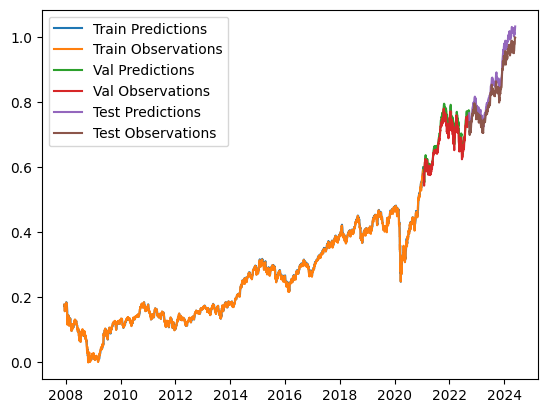

In [36]:
model7_preds = prediction(model7, dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test)

In [37]:
rmse_train = np.sqrt(np.mean(((model7_preds[0] - y_train) ** 2)))
rmse_val = np.sqrt(np.mean(((model7_preds[1] - y_val) ** 2)))
rmse_test = np.sqrt(np.mean(((model7_preds[2] - y_test) ** 2)))

rmse_train, rmse_val, rmse_test

(0.004886459437626461, 0.01874834317270222, 0.030929319802617813)

In [ ]:
(0.005314863638832331, 0.010983309016109022, 0.010618368091226594)
(0.0045111471538190825, 0.008867011019022899, 0.00832532719125168)

In [38]:
# rmse_train = np.sqrt(np.mean(((model6_preds[0] - y_train) ** 2)))
# rmse_val = np.sqrt(np.mean(((model6_preds[1] - y_val) ** 2)))
# rmse_test = np.sqrt(np.mean(((model6_preds[2] - y_test) ** 2)))

# rmse_train, rmse_val, rmse_test

model5s_preds = scaler.inverse_transform(np.array(model5_preds[2]).reshape(-1, 1))
y_test_normal = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
diff_normal = model5s_preds - y_test_normal

model_pred_df = pd.DataFrame(data={
    'Test Data': y_test_normal.flatten(),
    'Model Preds': model5s_preds.flatten(),
    'Difference': diff_normal.flatten(),
})

In [39]:
model_pred_df['Difference'].max()

429.24999975000173

In [40]:
model_pred_df['Difference'].min()

-435.8632816249992

In [41]:
model_pred_df['Difference'].describe()

count    411.000000
mean     -37.098293
std      133.531519
min     -435.863282
25%     -128.083008
50%      -42.720703
75%       50.831055
max      429.250000
Name: Difference, dtype: float64

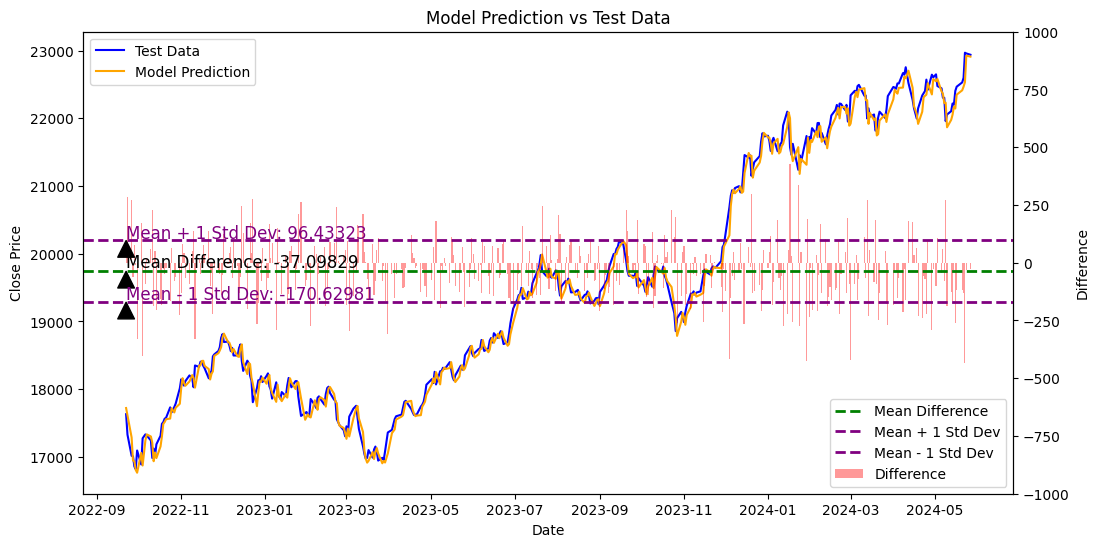

In [42]:
start_range = 0
end_range = len(model_pred_df)

mean_diff = model_pred_df['Difference'][start_range:end_range].mean()
std_dev_diff  = model_pred_df['Difference'][start_range:end_range].std()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the actual test data and model predictions
ax1.plot(dates_test[start_range:end_range], model_pred_df['Test Data'][start_range:end_range], label='Test Data', color='blue')
ax1.plot(dates_test[start_range:end_range], model_pred_df['Model Preds'][start_range:end_range], label='Model Prediction', color='orange')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price')
ax1.set_title('Model Prediction vs Test Data')
ax1.legend(loc='upper left')

# Create a secondary y-axis to plot the differences
ax2 = ax1.twinx()
ax2.bar(dates_test[start_range:end_range], model_pred_df['Difference'][start_range:end_range], alpha=0.4, color='red', label='Difference')
ax2.set_ylim(-1000, 1000)
ax2.set_ylabel('Difference')

ax2.axhline(y=mean_diff, color='green', linestyle='--', linewidth=2, label='Mean Difference')
ax2.annotate(f'Mean Difference: {mean_diff:.5f}', xy=(dates_test[start_range], mean_diff), xytext=(dates_test[start_range], mean_diff + 15),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='black')

ax2.axhline(y=mean_diff + std_dev_diff, color='purple', linestyle='--', linewidth=2, label='Mean + 1 Std Dev')
ax2.axhline(y=mean_diff - std_dev_diff, color='purple', linestyle='--', linewidth=2, label='Mean - 1 Std Dev')
ax2.annotate(f'Mean + 1 Std Dev: {mean_diff + std_dev_diff:.5f}', xy=(dates_test[start_range], mean_diff + std_dev_diff), xytext=(dates_test[start_range], mean_diff + std_dev_diff + 10),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='purple')
ax2.annotate(f'Mean - 1 Std Dev: {mean_diff - std_dev_diff:.5f}', xy=(dates_test[start_range], mean_diff - std_dev_diff), xytext=(dates_test[start_range], mean_diff - std_dev_diff + 10),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='purple')


ax2.legend(loc='lower right')

plt.show()

In [44]:
import joblib

# Save the model
model5.save('model5_n.keras')

# Save the scaler
joblib.dump(scaler, 'scaler_n.pkl')

['scaler_n.pkl']

In [45]:
from tensorflow.keras.models import load_model
import joblib

# Load the model
loaded_model = load_model('model5_n.keras')

# Load the scaler
loaded_scaler = joblib.load('scaler_n.pkl')

d:\Downloads\nifty_prediction_LSTM_Keras\venv\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [46]:
def predict_next_price(model, scaler, new_data, sequence_length=60):
    # Ensure the new data is a numpy array
    new_data = np.array(new_data).reshape(-1, 1)

    # Scale the new data using the same scaler used during training
    scaled_new_data = scaler.transform(new_data)

    # Prepare the input sequence
    input_sequence = scaled_new_data[-sequence_length:].reshape(1, sequence_length, 1)  # Shape should be (1, sequence_length, 1)

    # Predict the next value
    predicted_scaled_value = model.predict(input_sequence)

    # Denormalize the predicted value
    predicted_value = scaler.inverse_transform(predicted_scaled_value)[0][0]

    return predicted_value

In [47]:
# Example usage with new data
import yfinance as yf

nifty = yf.Ticker("^NSEI")

df = nifty.history(period='max')

new_data = df['Close'][-60:].values

next_price = predict_next_price(loaded_model, loaded_scaler, new_data)
print(f"Predicted next close price: {next_price}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Predicted next close price: 22859.97265625


In [53]:
import datetime as dt

# Load data for NIFTY
nifty = yf.Ticker("^NSEI")

# Retrieve historical data
df = nifty.history(period='max')

# Get current date and time
current_time = dt.datetime.now()

# If current time is less than 15:31, get data from last 61 to yesterday, else get last 60
if current_time.time() < dt.time(15, 31):
    # Calculate yesterday's date
    yesterday = current_time - dt.timedelta(days=1)
    # Retrieve data from last 61 to yesterday
    new_data = df['Close'][-61:-1].values
else:
    # Retrieve data from last 60
    new_data = df['Close'][-60:].values

# Display new data
print(new_data)

[22217.44921875 22212.69921875 22122.05078125 22198.34960938
 21951.15039062 21982.80078125 22338.75       22405.59960938
 22356.30078125 22474.05078125 22493.55078125 22332.65039062
 22335.69921875 21997.69921875 22146.65039062 22023.34960938
 22055.69921875 21817.44921875 21839.09960938 22011.94921875
 22096.75       22004.69921875 22123.65039062 22326.90039062
 22462.         22453.30078125 22434.65039062 22514.65039062
 22513.69921875 22666.30078125 22642.75       22753.80078125
 22519.40039062 22272.5        22147.90039062 21995.84960938
 22147.         22336.40039062 22368.         22402.40039062
 22570.34960938 22419.94921875 22643.40039062 22604.84960938
 22648.19921875 22475.84960938 22442.69921875 22302.5
 22302.5        21957.5        22055.19921875 22104.05078125
 22217.84960938 22200.55078125 22403.84960938 22466.09960938
 22529.05078125 22597.80078125 22967.65039062 22957.09960938]
